In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

In [109]:
"""!git clone https://elsaessern:@github.com/SimonEnsemble/cof-sensor-array-v2.git
%cd /content/cof-sensor-array-v2/

!git config --global user.name "elsaessern"
!git config --global user.email "nik2000615@gmail.com"
!git config --global user.password "" """

'!git clone https://elsaessern:@github.com/SimonEnsemble/cof-sensor-array-v2.git\n%cd /content/cof-sensor-array-v2/\n\n!git config --global user.name "elsaessern"\n!git config --global user.email "nik2000615@gmail.com"\n!git config --global user.password "" '

# Helpers to read in response data

In [3]:
ppms = [2.5, 5, 10, 20, 40, 80]

"""
    _find_ppm_sheet(filname, ppm)

read in excel file and check the sheet names which include the ppm number.
80 ppm is always the first sheet in data, so only called when ppm != 80
"""

def _find_ppm_sheet(filename, ppm):
    xlfl = pd.ExcelFile(filename)
    sheet_names = xlfl.sheet_names

    if ppm == 80: #80 ppm data will either be named in sheet "80 ppm" or is the default Sheet1
        target_sheet = [sheet for sheet in sheet_names if (str(ppm) in sheet) or ('Sheet1' in sheet)][0]
    else: # other ppm sheets named "x ppm"
        target_sheet = [sheet for sheet in sheet_names if str(ppm) in sheet][0]

    return target_sheet

"""
    _find_header_row(filename, search_terms=['Time', 's'])

read in excel file and check first ten rows for search terms.
return the first row in which a search term appears.
if not found, return None.
"""
def _find_header_row(filename, ppm_sheet=0, search_terms=['Time', 's']):
    for i in range(10):  # Check first 10 rows
        try:
            df = pd.read_excel(filename, sheet_name=ppm_sheet, header=i, nrows=1)
            for search_term in search_terms:
                if search_term in df.columns:
                    return i
        except:
            pass
    return None  # If header not found

"""
    read_data(cof, gas, carrier, ppm)

read in the sensor response data for a given COF exposed to a
given gas with a given carrier at a given concentration.
returns list of pandas data frames with this data. (may be replicates)
each data frame has two columns: time, DeltaG/G0.

note: this is complicated because there are two formats for a given
cof, gas, carrier, ppm:
(1) multiple replicates in the same file
(2) multiple replicates in separate files
"""
def read_data(cof, gas, carrier, ppm):

    if gas=='CO' and cof=='Fe-COF-DC-8' and carrier=='N2_dry': # carrier folder for this specific experiment is "dry_N2" instead of "N2_dry"
      carrier = 'dry_N2'

    # get path to appropriate file
    if (ppm in ppms) and (ppm != 80): # if ppm is 5, 10, 20 or 40, data will be in folder titled "original"
        path = Path.cwd().joinpath("Raw_sensing_data", gas, cof, carrier, "original").rglob("*.xlsx")

    else:
        path = Path.cwd().joinpath("Raw_sensing_data", gas, cof, carrier,).rglob("*.xlsx")

    # some folders contain multiple excel files, so create a list
    files = [file for file in path]

    # extract data from Excel files in list
    dfs = []
    for filename in files:
        ppm_sheet = None
        # if ppm 2.5, 5, 10, 20, or 40, get appropriate sheet name.
        # don't include for 80 ppm, since 80ppm is default the first sheet in all data and
        #doesn't always have '80' in the sheet name
        if ppm in ppms:
            ppm_sheet = _find_ppm_sheet(filename, ppm)
            # read in file (need to find header row; not consistent)
            header_row = _find_header_row(filename, ppm_sheet)
            df = pd.read_excel(filename, sheet_name=ppm_sheet, header=header_row)

        else:
            raise Exception("PPM not supported.")

        # chop time data for begin and end of exposure (check later)
        #    only keep a subset of the cols (Time and (perhaps multiple) with muA's)
        ids_cols_keep = df.columns.str.contains('A', na=False) | (df.columns == 's') | (df.columns == 'Time')
        if 'Time' in df.columns: # keep time column consistent, label by unit (seconds)
            df = df.rename(columns={"Time": "s"})
        # exposure time begins at 750s, ends 2580s later (3330s)
        start_index = df.index[df['s']==750].tolist()[0]
        end_index = df.index[df['s']==3330].tolist()[0]
        df = df.loc[start_index:end_index, df.columns[ids_cols_keep]]

        # check time is sliced properly
        assert df.iloc[0]["s"] == 750.0
        assert df.iloc[-1]["s"] == 3330.0
        # reshift time
        df["s"] = df["s"] - 750.0

        # drop columns with missing values
        df = df.dropna(axis='columns')

        df.reset_index(drop=True, inplace=True)

        # separate replicates into differente dataframes and append to dfs
        for i in df.columns:
            if 'A' in i and not np.all(df[i] == 0):
                data_rep = df[['s', i]]
                G0 = df[i].iloc[0]
                # replace muA column with -deltaG/G0 calculation: -ΔG/G0 = -(muA - G0)/G0 * 100
                data_rep.loc[:, i] = 100*(-(data_rep.loc[:, i]-G0)/G0)
                data_rep = data_rep.rename(columns={i: "-ΔG/G0"})
                dfs.append(data_rep)

    return dfs

In [4]:
read_data("Fe-COF-DC-8", "CO", "N2_dry", 80)

[           s    -ΔG/G0
 0        0.0 -0.000000
 1        0.5 -0.000000
 2        1.0 -0.000000
 3        1.5  0.054318
 4        2.0  0.054318
 ...      ...       ...
 5156  2578.0 -3.747963
 5157  2578.5 -3.747963
 5158  2579.0 -3.693645
 5159  2579.5 -3.693645
 5160  2580.0 -3.693645
 
 [5161 rows x 2 columns],
            s    -ΔG/G0
 0        0.0 -0.000000
 1        0.5 -0.000000
 2        1.0 -0.000000
 3        1.5 -0.000000
 4        2.0 -0.000000
 ...      ...       ...
 5156  2578.0 -3.333333
 5157  2578.5 -3.333333
 5158  2579.0 -3.282828
 5159  2579.5 -3.282828
 5160  2580.0 -3.282828
 
 [5161 rows x 2 columns],
            s    -ΔG/G0
 0        0.0 -0.000000
 1        0.5 -0.000000
 2        1.0 -0.000000
 3        1.5 -0.000000
 4        2.0 -0.000000
 ...      ...       ...
 5156  2578.0 -2.163062
 5157  2578.5 -2.163062
 5158  2579.0 -2.163062
 5159  2579.5 -2.163062
 5160  2580.0 -2.218525
 
 [5161 rows x 2 columns],
            s    -ΔG/G0
 0        0.0 -0.000000
 1  

# Helper function to run linear regression


In [5]:
"""
    linear_regression(df, ids_split)

perform linear regression on df[ids_split]:
ΔG/G0 = m * t + b

# arguments:
* df := dataframe of a single partition of sensor_response data
* ids_split := indices of response data partition

# output: dict of:
* coef := coefficient from linear regression
* r2 := r2 score
* ids_split
"""
def linear_regression(df, ids_split):
    X = df.loc[ids_split, "s"].to_numpy().reshape(-1, 1)
    y = df.loc[ids_split, "-ΔG/G0"].to_numpy()

    reg = LinearRegression().fit(X, y)

    r2 = reg.score(X, y)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    return {'slope': slope, 'r2': r2, 'ids_split': ids_split, 'intercept': intercept}

# Class to extract response features

In [6]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm, replicate_id):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm
        self.replicate_id = replicate_id

        try:
            self.data = read_data(cof, gas, carrier_gas, ppm)[replicate_id]
        except IndexError:
            print(f"Error: replicate_id {replicate_id} does not exist for {gas} ({carrier_gas}) in {cof} at {ppm} ppm.")

        # store features
        self.slope_info = None
        self.saturation = None
        self.auc = None

    """
    compute_initial_slope(self, partition_size, total_time_window, mse_bound)
    estimate initial slope of data.

      arguments:
          * max_time := indicates the window of time from 0 to max_time to partition data
          * n_partitions := number of partitions
          * r2_bound := bound on acceptable r-squared values from linear regression
    """
    def compute_initial_slope(self, n_partitions=15, max_time=750.0, r2_bound=0):
        early_df = self.data[self.data["s"] < max_time]

        # partition data indices
        ids_splits = np.array_split(early_df.index, n_partitions)

        # create list of regression on each partition of data which satisfy the mean_squared error bound
        regression_data = [linear_regression(early_df, ids_split) for ids_split in ids_splits]
        # filter according to r2
        regression_data = list(filter(lambda res: res['r2'] > r2_bound, regression_data))

        if len(regression_data) == 0:
            raise Exception("Data has no initial slopes that satisfy r2 bound.")

        # find index of max absolute value of linear regression coefficients
        id_initial_slope = np.argmax([np.abs(rd['slope']) for rd in regression_data])

        # return regression_data which contains the initial slope
        self.slope_info = regression_data[id_initial_slope]
        return self.slope_info

    def compute_saturation(self, n_partitions=100):
        ids_splits = np.array_split(self.data.index, n_partitions)

        # get mean over partitions
        means = [np.mean(self.data.iloc[ids_split]['-ΔG/G0']) for ids_split in ids_splits]

        id_max_magnitude = np.argmax(np.abs(means))

        self.saturation = means[id_max_magnitude]
        return self.saturation

    def compute_features(self, n_partitions_saturation=100, n_partitions_slope=15, r2_bound_slope=0):
        self.compute_saturation(n_partitions=n_partitions_saturation)
        self.compute_initial_slope(n_partitions=n_partitions_slope, r2_bound=r2_bound_slope)
        self.compute_area_under_response_curve()

    # compute area under curve for each GBx DeltaG/G0 using sklearn auc
    def compute_area_under_response_curve(self):
        self.auc = auc(self.data["s"], self.data['-ΔG/G0'])
        return self.auc

    def viz(self, save=True): # viz the data along with the response features or function u fit to it.
        if self.slope_info == None or self.saturation == None:
            raise Exception("Compute feautres first.")

        fig, ax = plt.subplots()

        plt.xlabel("time [s]")
        plt.ylabel("$\Delta G/G_0$")

        # plot raw response data
        plt.scatter(self.data['s'], self.data['-ΔG/G0'])

        ###
        #   viz features
        ###
        # saturation
        plt.axhline(self.saturation, linestyle='-', color="gray")

        # slope
        t_start = self.data.loc[self.slope_info["ids_split"][0], 's']
        t_end = self.data.loc[self.slope_info["ids_split"][-1], 's']
        plt.plot(
            [t_start, t_end],
            self.slope_info["slope"] * np.array([t_start, t_end]) + self.slope_info["intercept"],
            color='orange'
        )

        all_info = "{}_{}_{}_{}ppm_{}".format(self.cof, self.gas, self.carrier_gas,
                                                     self.ppm, self.replicate_id)
        plt.title(all_info)
        # create inset axes & plot initial slope data on them
        # ins_ax = fig.add_axes([0.6,0.2,0.3,0.3])
        # ins_ax.scatter(self.data.loc[initial_slope[3], 's'], self.data.loc[initial_slope[3], 'ΔG/G0'])
        # ins_ax.plot(self.data.loc[initial_slope[3], 's'], initial_slope[2], color = 'orange')

        if save:
            plt.savefig("responses/featurized_{}.png".format(all_info), format="png")
        plt.show()


    # def vector_representation(self,docnum=0): # returns the vector characterizing the response.
    #     response = []
    #     response.append(self.compute_initial_slope(k=docnum)[0])
    #     response.append(self.compute_saturation(k=docnum))
    #     response.append(self.compute_area(k=docnum))
    #     return response

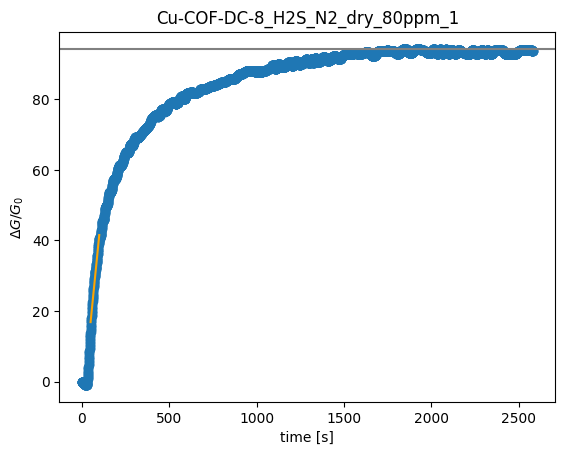

In [7]:
# Test the SensorResponse class initial_slope function
sensor_response = SensorResponse("Cu-COF-DC-8", "H2S", "N2_dry", 80, 1)
sensor_response.compute_features()
# sensor_response.compute_initial_slope(r2_bound=0.95)
sensor_response.viz(save=True)

In [8]:
read_data_from_file = True

In [9]:
gases = ['CO', 'H2S', 'NH3', 'NO']
cofs = ['Fe-COF-DC-8', 'Ni-COF-DC-8', 'Cu-COF-DC-8', 'Co-COF-DC-8']
carriers = ['air_dry', 'air_humid', 'N2_dry', 'N2_humid']
features = ['auc', 'slope', 'saturation']
ppms = [2.5, 5, 10, 20, 40, 80]

In [10]:
# list for data, will append cof, gas, carrier, and features of each sensor_response
data = []

for gas in gases:
    for cof in cofs:
        for carrier in carriers:
            for ppm in ppms:
                for rep_id in range(8):
                    if read_data_from_file:
                        continue

                    try:
                        sensor_response = SensorResponse(cof, gas, carrier, ppm, rep_id)

                        if gas == 'NH3' and cof == 'Co-COF-DC-8' and carrier == 'N2_humid':
                            sensor_response.compute_features(n_partitions_slope=3)
                        elif gas == 'NH3' and cof == 'Co-COF-DC-8' and carrier == 'air_humid':
                            sensor_response.compute_features(n_partitions_slope=6)
                        elif gas == 'CO' and cof == 'Ni-COF-DC-8' and carrier == 'N2_humid':
                            sensor_response.compute_features(n_partitions_slope=7)
                        elif gas == 'CO' and cof == 'Ni-COF-DC-8' and carrier in ['N2_dry', 'air_dry']:
                            sensor_response.compute_features(n_partitions_slope=5)#, r2_bound_slope=0.5)
                        elif gas == 'CO' and cof == 'Co-COF-DC-8' and carrier in ['air_humid', 'N2_humid']:
                            sensor_response.compute_features(n_partitions_slope=8)
                        else:
                            sensor_response.compute_features()

                        sensor_response.viz(save=True)
                        data.append([cof, gas, carrier, ppm, rep_id, sensor_response.slope_info['slope'],
                                  sensor_response.saturation, sensor_response.auc]) # be consistent with features above

                    except (AttributeError, Exception):
                      pass

In [11]:
# Put list of data into dataframe
if read_data_from_file:
    data_df = pd.read_csv("responses.csv")
    data_df.drop(columns=['Unnamed: 0'], inplace=True) # remove index column, artifact of reading in
else:
    data_df = pd.DataFrame(data, columns=['cof', 'gas', 'carrier', 'ppm', 'rep_id', 'slope', 'saturation', 'auc'])
    data_df.to_csv("responses.csv")
data_df

,cof,gas,carrier,ppm,rep_id,slope,saturation,auc
0,Fe-COF-DC-8,CO,N2_dry,10.0,0,-0.031296,7.675091,6.694230e+03
1,Fe-COF-DC-8,CO,N2_dry,10.0,1,0.013494,5.367292,6.330417e+03
2,Fe-COF-DC-8,CO,N2_dry,10.0,2,-0.005564,4.055674,3.285188e+03
3,Fe-COF-DC-8,CO,N2_dry,10.0,3,-0.012287,2.993199,1.656146e+03
4,Fe-COF-DC-8,CO,N2_dry,40.0,0,0.021180,13.606942,2.166002e+04
...,...,...,...,...,...,...,...,...
393,Co-COF-DC-8,NO,N2_humid,80.0,0,-10.145309,-3051.356808,-6.012587e+06
394,Co-COF-DC-8,NO,N2_humid,80.0,1,-8.144168,-3085.674813,-6.479762e+06
395,Co-COF-DC-8,NO,N2_humid,80.0,2,-13.467390,-5022.826344,-1.031188e+07
396,Co-COF-DC-8,NO,N2_humid,80.0,3,-13.007995,-4207.678547,-8.432174e+06


In [12]:
# Standardize data via Yeo-Johnson method
pt = PowerTransformer('yeo-johnson')

standardized_df = data_df.copy()
standardized_df[['slope', 'saturation', 'auc']] = pt.fit_transform(data_df[['slope', 'saturation', 'auc']])
standardized_df.to_csv("standardized_responses.csv")
standardized_df.loc[(standardized_df['gas']=='H2S') & (standardized_df['carrier']=='N2_dry')
                    & (standardized_df['rep_id']==3) & (standardized_df['ppm']==80)
                    & (standardized_df['cof']=='Fe-COF-DC-8')]['slope'].iloc[0]

0.5662996955237491

# Loop through sensor response data to assemble complete array response vectors

In [13]:
# matrix will store response features.
#  col = sensor array response vector
#  row = particular response feature for a particular COF (12. 4 COFs x 3 feature each)
#  loop through data to build matrix column by column (technically row by row and then transpose)

matrix = []
experiments = [] # List which will store experiment setup for each array column


for gas in gases:
  for carrier in carriers:
      for ppm in ppms:
          for rep in range(5):
              col = []
              experiment = {'gas': gas,
                            'carrier': carrier,
                            'ppm': ppm,
                            'rep_id': rep}
              for cof in cofs:
                  for feature in features:
                    # try to access matching data and append to column
                    try:
                      col.append(standardized_df.loc[(standardized_df['gas']==gas)
                                  & (standardized_df['cof']==cof)
                                  & (standardized_df['carrier']==carrier)
                                  & (standardized_df['rep_id']==rep)
                                  & (standardized_df['ppm']==ppm)][feature].iloc[0])
                    except (IndexError, KeyError):
                      pass
              # only append column if entire array response exists
              if len(col) == len(cofs) * len(features):
                  matrix.append(col)
                  experiments.append(experiment)

              else:
                  print("No complete array for experiment: ", experiment)


matrixdf = pd.DataFrame(matrix)




No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 2.5, 'rep_id': 0}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 2.5, 'rep_id': 1}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 2.5, 'rep_id': 2}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 2.5, 'rep_id': 3}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 2.5, 'rep_id': 4}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 5, 'rep_id': 0}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 5, 'rep_id': 1}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 5, 'rep_id': 2}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 5, 'rep_id': 3}
No complete array for experiment:  {'gas': 'CO', 'carrier': 'air_dry', 'ppm': 5, 'rep_id': 4}
No complete array for experiment:  {'gas': 'CO', '

In [14]:
matrixdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.416413,0.001308,-0.370608,-0.199916,0.013939,-0.116580,-0.439825,-0.059409,-0.418398,-0.442887,-0.047738,-0.431879
1,-0.413161,0.001001,-0.368952,-0.438390,-0.031489,-0.405037,-0.438718,-0.016590,-0.411712,-0.442145,-0.046704,-0.428879
2,-0.409262,0.000326,-0.370880,-0.391056,-0.008309,-0.376344,-0.438452,-0.007325,-0.414927,-0.441782,-0.052303,-0.427887
3,-0.409262,0.000326,-0.370880,-0.396577,-0.009058,-0.380477,-0.429686,-0.013845,-0.400352,-0.442568,-0.048556,-0.430064
4,0.116963,0.047685,0.166375,-0.415609,-0.008806,-0.385218,1.464536,0.431538,1.441815,-0.038330,0.039697,-0.030215


In [15]:
experiments

[{'gas': 'CO', 'carrier': 'N2_dry', 'ppm': 80, 'rep_id': 0},
 {'gas': 'CO', 'carrier': 'N2_dry', 'ppm': 80, 'rep_id': 1},
 {'gas': 'CO', 'carrier': 'N2_dry', 'ppm': 80, 'rep_id': 2},
 {'gas': 'CO', 'carrier': 'N2_dry', 'ppm': 80, 'rep_id': 3},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 10, 'rep_id': 0},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 10, 'rep_id': 1},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 10, 'rep_id': 2},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 10, 'rep_id': 3},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 20, 'rep_id': 0},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 20, 'rep_id': 1},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 20, 'rep_id': 2},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 20, 'rep_id': 3},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 40, 'rep_id': 0},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 40, 'rep_id': 1},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 40, 'rep_id': 2},
 {'gas': 'H2S', 'carrier': 'N2_dry', 'ppm': 40, 'rep_id': 3},
 {'gas': 'H2

In [16]:
# transpose to get complete arrays as columns for heatmap
heatmatrixdf = matrixdf.T


In [17]:
heatmatrixdf

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,-0.416413,-0.413161,-0.409262,-0.409262,0.116963,0.144715,0.163834,0.160839,0.439596,0.492667,...,-0.518074,-0.516785,-0.522873,-0.554680,-0.552219,-0.571079,-0.766587,-0.791442,-0.827189,-0.823493
1,0.001308,0.001001,0.000326,0.000326,0.047685,0.052011,0.055601,0.059555,0.121601,0.140889,...,-0.769546,-0.784270,-0.810111,-0.831465,-0.942956,-1.094849,-1.682193,-1.716152,-1.749211,-1.766211
2,-0.370608,-0.368952,-0.370880,-0.370880,0.166375,0.192553,0.213510,0.207715,0.461642,0.516838,...,-0.593453,-0.590956,-0.602716,-0.621358,-0.621945,-0.648291,-0.890330,-0.919534,-0.955947,-0.956001
3,-0.199916,-0.438390,-0.391056,-0.396577,-0.415609,-0.435542,-0.439814,-0.400415,0.176556,0.102592,...,-0.601885,-0.618574,-0.596969,-0.808855,-0.594647,-0.952877,-1.581227,-1.535920,-1.724117,-1.635823
4,0.013939,-0.031489,-0.008309,-0.009058,-0.008806,-0.010198,-0.008783,-0.007504,0.030841,0.049845,...,-0.430881,-0.427861,-0.408159,-0.727611,-0.367357,-0.926046,-1.782910,-1.781402,-1.817550,-1.814905
5,-0.116580,-0.405037,-0.376344,-0.380477,-0.385218,-0.420962,-0.428041,-0.379550,0.235361,0.139176,...,-0.726335,-0.754109,-0.720982,-0.990884,-0.705582,-1.119557,-1.498230,-1.481878,-1.602668,-1.552306
6,-0.439825,-0.438718,-0.438452,-0.429686,1.464536,1.349913,1.464613,1.466598,1.317534,1.409741,...,-0.839132,-0.843268,-0.838017,-1.315811,-1.312484,-1.452059,-1.612631,-1.820390,-1.635822,-1.604865
7,-0.059409,-0.016590,-0.007325,-0.013845,0.431538,0.308808,0.469218,0.421116,0.620427,0.796652,...,-0.933910,-0.929286,-0.917247,-1.312417,-1.291357,-1.388334,-1.569382,-1.627823,-1.584838,-1.584428
8,-0.418398,-0.411712,-0.414927,-0.400352,1.441815,1.370995,1.426280,1.440316,1.480676,1.501726,...,-1.021894,-1.031028,-1.027107,-1.435456,-1.441564,-1.539575,-1.611288,-1.760432,-1.623920,-1.595190
9,-0.442887,-0.442145,-0.441782,-0.442568,-0.038330,-0.109824,-0.014618,-0.283055,0.562743,0.174918,...,-0.753737,-0.760293,-0.790535,-1.701324,-1.600353,-1.438442,-0.892782,-0.801722,-0.772033,-0.819680


# Create heatmap

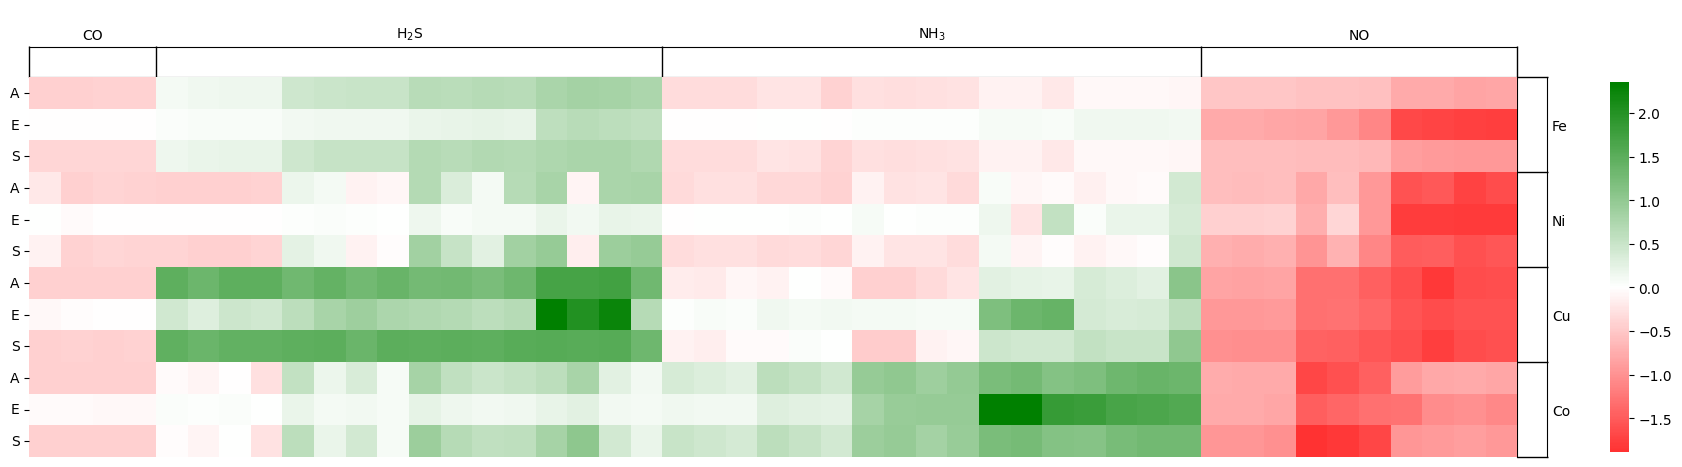

In [18]:
RdGn = cmap = LinearSegmentedColormap.from_list("mycmap", ["red", "white", "green"])

fig, ax = plt.subplots(figsize=(24, 6))

# tick labels for features (A: area under curve, E: initial slope, S: saturation)
yticklabels = ['A', 'E', 'S'] * 4

# count number of experiments for each type of gas
gas_counts = {gas: sum(exp.get('gas') == gas for exp in experiments) for gas in gases}

# create heatmap
sns.heatmap(heatmatrixdf, cmap=RdGn, center=0, yticklabels=yticklabels,
                 cbar_kws={'shrink':0.8}, square=True)

# label the gases:
sec = ax.secondary_xaxis(location=1.08)
sec.set_xticks([gas_counts['CO']/2, gas_counts['H2S']/2+gas_counts['CO'],
                gas_counts['NH3']/2+gas_counts['H2S']+gas_counts['CO'],
                gas_counts['NO']/2+gas_counts['NH3']+gas_counts['H2S']+gas_counts['CO']],
               labels=['\nCO', '\nH$_2$S', '\nNH$_3$', '\nNO'])
sec.tick_params('x', length=0)

# lines between the gases:
sec2 = ax.secondary_xaxis(location=1)
sec2.set_xticks([0, gas_counts['CO'],
                 gas_counts['H2S']+gas_counts['CO'],
                 gas_counts['NH3']+gas_counts['H2S']+gas_counts['CO'],
                 gas_counts['NO']+gas_counts['NH3']+gas_counts['H2S']+gas_counts['CO']], labels=[])
sec2.tick_params('x', length=22, width=1)

# label the cofs:
sec = ax.secondary_yaxis(location=1.02)
sec.set_yticks([1.5, 4.5, 7.5, 10.5],
               labels=['Fe', 'Ni', 'Cu', 'Co'])
sec.tick_params('y', length=0)

# lines between the cofs:
sec2 = ax.secondary_yaxis(location=1)
sec2.set_yticks([0, 3, 6, 9, 12] , labels=[])
sec2.tick_params('y', length=22, width=1)

ax.set_xticks([])

plt.yticks(rotation=0)
plt.savefig("heatmap.pdf")
plt.show()

In [19]:
# Attempt at PCA

pcadata = matrixdf.copy()

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(pcadata)
z1, z2 = pca.explained_variance_ratio_
print(z1, z2)

pcs = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pcs_and_exps = pd.concat([pd.DataFrame(experiments), pcs], axis = 1) # add principal components to f

0.7688067664360084 0.15279615405271144


In [20]:
pcs_and_exps

,gas,carrier,ppm,rep_id,PC1,PC2
0,CO,N2_dry,80,0,1.026032,-0.075383
1,CO,N2_dry,80,1,1.130769,-0.043379
2,CO,N2_dry,80,2,1.108270,-0.050126
3,CO,N2_dry,80,3,1.103043,-0.056232
4,H2S,N2_dry,10,0,-1.083694,-1.190203
5,H2S,N2_dry,10,1,-0.911913,-1.196405
6,H2S,N2_dry,10,2,-1.113006,-1.177169
7,H2S,N2_dry,10,3,-0.950657,-1.430451
8,H2S,N2_dry,20,0,-1.926361,-0.762821
9,H2S,N2_dry,20,1,-1.763514,-1.211311


In [21]:
# prompt: Using dataframe pcs_and_exps: Make a 2d bubble plot with PC1 on the x-axis and PC2 on the y-axis, have only edge color based on gas and size based on ppm, have 2 separate legends for gas and ppm

import altair as alt
alt.Chart(pcs_and_exps).mark_point().encode(
    alt.X('PC1', title='PC1 score, ' + 'z1 ['+str(round(z1, 3)*100) + '%]',
          scale=alt.Scale(domain=(-5,5)), axis=alt.Axis(tickMinStep=5)),
    alt.Y('PC2', title='PC2 score, ' + 'z2 ['+str(round(z2, 4)*100) + '%]',
          scale=alt.Scale(domain=(-2.5,2.5)), axis=alt.Axis(tickMinStep=4)),
    color=alt.Color('gas', legend=alt.Legend(title="Gas type")),
    size=alt.Size('ppm', legend=alt.Legend(title="Concentration (ppm)", orient='bottom'))
).configure_mark(
    filled=False
).configure_axis(
    grid=False
).properties(
    width=500,
    height=250
)


/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

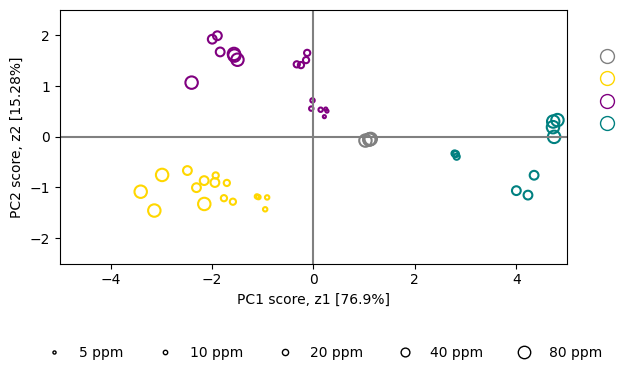

In [107]:
pc1 = pcs_and_exps['PC1']
pc2 = pcs_and_exps['PC2']
gas = pcs_and_exps['gas']
ppm = pcs_and_exps['ppm']

# create dictionary for gas and corresponding colors
colordict = {'CO': 'grey', 'H2S': 'gold', 'NH3': 'purple', 'NO': 'teal'}

fig, ax = plt.subplots()

gas_types = [('CO','CO'),('H2S','H$_2$S'),('NH3','NH$_3$'),('NO','NO')] # gas label for accessing data and gas label for legend
ppm_values = pcs_and_exps['ppm'].unique()


ppm_values.sort()

# create the bubble plot and legend handles
gas_legend_elements = []
ppm_legend_elements = []
for gas_type, gas_label in gas_types:
    gas_mask = (gas == gas_type)
    scatter = ax.scatter(pc1[gas_mask], pc2[gas_mask], s=(ppm[gas_mask]),
                         edgecolors=colordict[gas_type], linewidths=1.5, facecolors='none')
    gas_legend_elements.append(Line2D([0], [0], marker='o', color='w', label=gas_label,
                                      markeredgecolor=colordict[gas_type], markerfacecolor='none', markersize=10))

ppm_legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(ppm_value)+" ppm",
                        markerfacecolor='w', markeredgecolor='black', ms=np.sqrt(ppm_value)) for ppm_value in ppm_values]

# set x and y axis labels and limits
ax.set_xlabel(f'PC1 score, z1 [{round(z1, 3)*100}%]')
ax.set_ylabel(f'PC2 score, z2 [{round(z2, 4)*100}%]')
ax.grid(False)

# create the legends
gas_legend = ax.legend(handles=gas_legend_elements, title=None, loc=(1.04,.5), frameon=False)
ppm_legend = ax.legend(handles=ppm_legend_elements, title=None, loc=(-0.05,-0.4),
                       ncol=len(ppm_values), frameon=False)

ax.add_artist(gas_legend)
#ax.add_artist(ppm_legend)


plt.axis('scaled')
plt.xlim(-5,5)
plt.ylim(-2.5,2.5)

plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')



plt.tight_layout()

# Adjust the layout
plt.savefig("PCA.pdf", bbox_extra_artists=(gas_legend, ppm_legend), bbox_inches='tight')
plt.show()


In [108]:
!git add .
!git commit -m "Added labels to heatmap, fixed formatting on PCA plot"
!git push

[main eaef455] Added labels to heatmap, fixed formatting on PCA plot
 3 files changed, 0 insertions(+), 0 deletions(-)
 delete mode 100644 heatmap.png
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 18.93 KiB | 6.31 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SimonEnsemble/cof-sensor-array-v2.git
   139e396..eaef455  main -> main
